<a href="https://colab.research.google.com/github/bhuvnk/EVA/blob/master/Assignment10/Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part1: Finding Tony Stark's Glasses


# **Import Libraries and modules**

In [1]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, Activation
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
import keras.backend as K

from keras.utils import np_utils
from keras.datasets import mnist
import matplotlib.pyplot as plt

Using TensorFlow backend.


# GRADCAM

Let's start with a pretrained VGG model

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [3]:
model = VGG16(weights="imagenet")


W0706 20:13:00.719979 140190983337856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0706 20:13:00.767818 140190983337856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0706 20:13:00.774275 140190983337856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0706 20:13:00.813350 140190983337856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 9s 0us/step


W0706 20:13:10.509468 140190983337856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0706 20:13:10.510613 140190983337856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Function to look at things

In [0]:
from skimage import io
from google.colab.patches import cv2_imshow

def whatchyalookingat(img_loc, layer_n, class_idx=None, model=model):
  img = io.imread(img_loc)
  img = cv2.resize(img, dsize=(224, 224))
#   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  x = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  
  preds = model.predict(x)
  if class_idx==None:
    class_idx = np.argmax(preds[0])
#   print(class_idx)
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer_n)
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
#   print(grads.shape)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
#   print(pooled_grads.shape)
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(last_conv_layer.output_shape[3]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
  heatmap = np.mean(conv_layer_output_value, axis = -1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
   
  superimposed_img = cv2.addWeighted(img, 0.65, heatmap, 0.35, 0)
  return(superimposed_img)

In [0]:
def show_me_it(image, layers, class_idx=None,model=model ):
  fig = plt.figure(figsize=(18,8))
  for i in range(len(layers)+1):
    if i ==0:
      ax = fig.add_subplot(1, len(layers)+1, i+1, xticks=[], yticks=[])
      ax.set_title('Original Image')
      im = io.imread(image)
      im = cv2.resize(im, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
      plt.imshow(im)
    else:
      im = whatchyalookingat(image, layers[i-1], class_idx=class_idx, model=model)
      
      ax = fig.add_subplot(1, len(layers)+1, i+1, xticks=[], yticks=[])
      ax.set_title(layers[i-1])
      plt.imshow(im)
      
  plt.show()

# Testing on Doggo

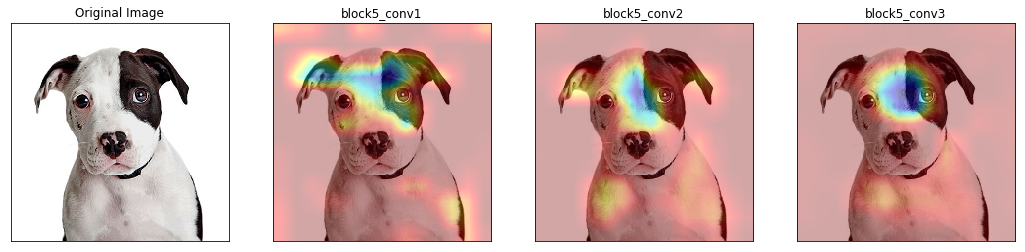

In [25]:
doggo = "https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg"
show_me_it(doggo,layers=['block5_conv1', 'block5_conv2', 'block5_conv3'])

# Finding Toney's Glasses

In [8]:
!wget https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg

--2019-07-06 20:13:27--  https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg
Resolving media.karousell.com (media.karousell.com)... 190.93.247.83, 190.93.244.83, 190.93.246.83, ...
Connecting to media.karousell.com (media.karousell.com)|190.93.247.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58670 (57K) [image/jpeg]
Saving to: ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg’

16_scale_tony_stark 100%[===================>]  57.29K  --.-KB/s    in 0.01s   

2019-07-06 20:13:27 (5.24 MB/s) - ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg’ saved [58670/58670]



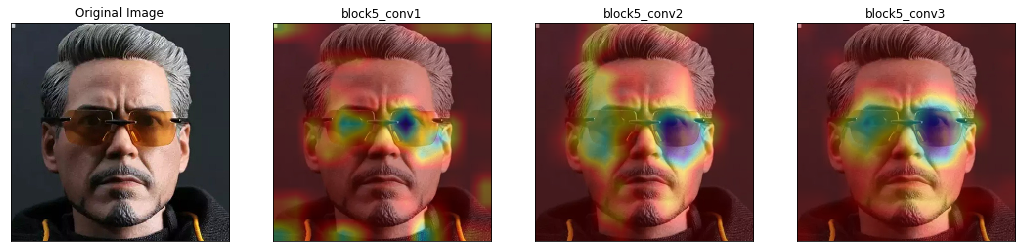

In [26]:
tony = '/content/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg'
show_me_it(tony,layers=['block5_conv1', 'block5_conv2', 'block5_conv3'],class_idx=837)

# Part2: Why is it increasing?

as explained at figure#17:

**Figure 17: The CNN used throughout the experiments. All convolutions use 3 x 3X 3 filters,
except otherwise stated. The 1 x 1 x 1-convolutions at the beginning of each expanding block
halve the number of feature maps of their input. The “Conv=2” layer at the beginning of each
contracting block is a 2-strided convolution which halves its input in each dimension.**

By this logic before the end of contraction path every second convolution has `stride=2`

Looking at the receptive field calculation right before the end of contraction path:

| Layer #        | Receptive Field | Stride | Jump |
| -------------- | --------------- | ------ | ---- |
| 1. Conv(3x3x3) | 3x3x3           | 1      | 1    |
| 2. Conv(3x3x3) | 5x5x5           | 2      | 2    |
| 3. Conv(3x3x3) | 9x9x9           | 1      | 2    |
| 4. Conv(3x3x3) | 13x13x13        | 2      | 4    |
| 5. Conv(3x3x3) | 21x21x21        | 1      | 4    |
| 6. Conv(3x3x3) | 29x29x29        | 2      | 8    |
|      |**end of contraction path**     |
| 7. Conv(3x3x3) | 45x45x45        | 1      | 8    |
|      |**and for deconvolutions the calculation changes** |